In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
import requests
import re
import pytrends
from pytrends.request import TrendReq
from pytrends import dailydata
from datetime import time
import datetime

In [4]:
df = pd.DataFrame({'date': pd.date_range('2020-09-01', '2021-10-21', freq='1H', closed='left')})
df_FINAL = pd.read_csv("external_data.csv", parse_dates=['date'])
df_FINAL = df_FINAL.drop(columns=["numer_sta","tx24", "tn24", "tminsol", "sw", "tw", "niv_bar", "geop", "phenspe1", "phenspe2", "phenspe3", "phenspe4", "nnuage4","ctype4", "hnuage4"])
df = pd.merge(df, df_FINAL, on="date", how="left")

In [5]:
for i in df:
    if i not in ['n', 'rr1']:
        df[i] = df[i].ffill()

In [6]:
df.head()

,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,rr24,nnuage1,ctype1,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3
0,2020-09-01 00:00:00,102050.0,-10.0,8.0,340.0,1.6,285.75,282.55,81.0,30000.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-01 01:00:00,102050.0,-10.0,8.0,340.0,1.6,285.75,282.55,81.0,30000.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-09-01 02:00:00,102050.0,-10.0,8.0,340.0,1.6,285.75,282.55,81.0,30000.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-09-01 03:00:00,101990.0,-60.0,6.0,290.0,1.1,283.95,282.05,88.0,25000.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-09-01 04:00:00,101990.0,-60.0,6.0,290.0,1.1,283.95,282.05,88.0,25000.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## LOCKDOWN

In [7]:
df["lockdown"] = [1 
                        if (i.date() >= pd.Timestamp(year=2020, month=3, day=12) and 
                            i.date() <= pd.Timestamp(year=2020, month=5, day=10)) or 
                            (i.date() >= pd.Timestamp(year=2020, month=10, day=14) and 
                             i.date() <= pd.Timestamp(year=2020, month=12, day=10)) or 
                            (i.date() >= pd.Timestamp(year=2021, month=3, day=31) and 
                             i.date() <= pd.Timestamp(year=2021, month=5, day=2))
                        else 0 
                        for i in df["date"]
                       ]

## CURFEW

In [8]:
df["curfew"] = [1 
                      if (i.date() >= pd.Timestamp(year=2021, month=5, day=3) and 
                          i.date() <= pd.Timestamp(year=2021, month=5, day=18) and
                          (i.time() >= time(19) or i.time() <= time(6))) or
                          (i.date() >= pd.Timestamp(year=2021, month=5, day=19) and 
                           i.date() <= pd.Timestamp(year=2021, month=6, day=8) and
                           (i.time() >= time(21) or i.time() <= time(6))) or
                          (i.date() >= pd.Timestamp(year=2021, month=6, day=9) and 
                           i.date() <= pd.Timestamp(year=2021, month=6, day=29) and
                           (i.time() >= time(23) or i.time() <= time(6)))
                      else 0 
                      for i in df["date"]
                     ]

## METRO TRAFFIC

In [9]:
df_metro = pd.read_csv("frequentation_metro_defense.csv", sep=";", parse_dates=['date'])
df_metro.head()

FileNotFoundError: [Errno 2] No such file or directory: 'frequentation_metro_defense.csv'

In [9]:
df["freq_metro"] = ""
for i in df["date"]:
    for j in df_metro["date"]:
        if i == j:
            ind_true = df[df['date'] == i].index.values
            ind_metro = df_metro[df_metro['date'] == i].index.values
            for k in range(24):
                df.at[ind_true[0] + k, 'freq_metro'] = df_metro.at[ind_metro[0], 'total']

## GOOGLE TRENDS

In [24]:
searches = ["velo electrique", "velib", "velib paris", "borne velib", "velo electrique prime",
            "velo electrique subvention", "velo tout chemin", "piste cyclable", "velo decathlon", 
            "achat de velo","greve transport", "station velib", "greve metro"]

In [39]:
def search_gtrend_df(l):
    """use a list to search words on G trends
    and return a df with date, search and the trend score"""
    pytrend = TrendReq()
    dicti = { }
    for trending in l :
        pytrend.build_payload([trending], timeframe='2020-08-30 2021-10-21', geo="FR-J")
        dicti[trending] = pytrend.interest_over_time()
    df = pd.concat(dicti, axis=1)
    df.columns = df.columns.droplevel(0)
    df = df.drop('isPartial', axis=1)
    df = df.reset_index()
    df = pd.melt(df, id_vars='date', value_vars=l)
    return df

In [40]:
df_gtrends = search_gtrend_df(searches)

k = 1
dicti = { }
for i in df_gtrends['date']:
    if k < 60 :
        ind_true = df_gtrends[df_gtrends['date'] == i].index.values
        #print(i.date(),ind_true)
        for j in ind_true:
            if i in dicti: dicti[i] += df_gtrends.at[j, 'value']
            else: dicti[i] = df_gtrends.at[j, 'value']
    else: break
    k += 1
    
data_items = dicti.items()
data_list = list(data_items)
df_googlet = pd.DataFrame(data_list)
df_googlet = df_googlet.rename(columns={0: "date", 1: "frequency"})

In [41]:
df_googlet.head()

,date,frequency
0,2020-08-30,665
1,2020-09-06,444
2,2020-09-13,755
3,2020-09-20,580
4,2020-09-27,347


In [42]:
for i in df["date"]:
    for j in df_googlet["date"]:
        if i == j:
            ind_true = df[df['date'] == i].index.values
            ind_metro = df_googlet[df_googlet['date'] == i].index.values
            df.at[ind_true[0], 'gtrends'] = df_googlet.at[ind_metro[0], 'frequency']

In [43]:
df['gtrends'] = df['gtrends'].ffill(limit=167)

## JOUR FERIE

In [10]:
df["ferie"] = [1 
                     if (i.date() == pd.Timestamp(year=2020, month=11, day=1)) or
                         (i.date() == pd.Timestamp(year=2020, month=11, day=11)) or
                         (i.date() == pd.Timestamp(year=2020, month=12, day=25)) or
                         (i.date() == pd.Timestamp(year=2021, month=1, day=1)) or
                         (i.date() == pd.Timestamp(year=2021, month=4, day=5)) or
                         (i.date() == pd.Timestamp(year=2021, month=5, day=1)) or
                         (i.date() == pd.Timestamp(year=2021, month=5, day=8)) or
                         (i.date() == pd.Timestamp(year=2021, month=5, day=13)) or
                         (i.date() == pd.Timestamp(year=2021, month=5, day=24)) or
                         (i.date() == pd.Timestamp(year=2021, month=7, day=14)) or
                         (i.date() == pd.Timestamp(year=2021, month=8, day=15))
                     else 0 
                     for i in df["date"]
                    ]

## VACANCES

In [11]:
df["vacances"] = [1 
                        if (i.date() >= pd.Timestamp(year=2020, month=10, day=17) and 
                            i.date() <= pd.Timestamp(year=2020, month=11, day=1)) or
                            (i.date() >= pd.Timestamp(year=2020, month=12, day=19) and 
                             i.date() <= pd.Timestamp(year=2021, month=1, day=3)) or
                            (i.date() >= pd.Timestamp(year=2021, month=2, day=13) and 
                             i.date() <= pd.Timestamp(year=2021, month=2, day=28)) or
                            (i.date() >= pd.Timestamp(year=2021, month=4, day=10) and 
                             i.date() <= pd.Timestamp(year=2021, month=4, day=25)) or
                            (i.date() >= pd.Timestamp(year=2021, month=5, day=12) and 
                             i.date() <= pd.Timestamp(year=2021, month=5, day=16)) or
                            (i.date() >= pd.Timestamp(year=2021, month=7, day=6) and 
                            i.date() <= pd.Timestamp(year=2021, month=9, day=6))
                        else 0 
                        for i in df["date"]
                       ]

## RUSH HOUR

In [12]:
df["rush_hour"] = [1
                         if (i.time() >= time(7, 30) and i.time() <= time(9, 30)) or
                         (i.time() >= time(17) and i.time() <= time(19, 30))
                    else 0 
                    for i in df["date"]]

## CAR TRAFFIC

In [13]:
df_cars = pd.read_csv("traffic_CE.csv", sep=";", parse_dates=['Date et heure de comptage'])
df_cars = df_cars.rename(columns={"Date et heure de comptage": "date", "Débit horaire": "debit_h", "Taux d'occupation" : "taux_occ"})
for _ in range(2):
    df_cars.drop(df_cars.columns[0], axis=1, inplace=True)
for _ in range(10):
    df_cars.drop(df_cars.columns[3], axis=1, inplace=True)
df_cars['date']=df_cars['date'].apply(lambda x: x.replace(tzinfo=None))

In [14]:
df = pd.merge(df, df_cars, on="date", how="left")

## GOOGLE MOBILITY

In [44]:
df_mobility = pd.read_csv("Mobility_Report.csv", sep=",")
df_mobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,FR,France,NaN,NaN,NaN,NaN,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,2021-01-01,-83.0,-87.0,-7.0,-69.0,-87,24.0
1,FR,France,NaN,NaN,NaN,NaN,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,2021-01-02,-47.0,-12.0,-27.0,-33.0,-32,10.0
2,FR,France,NaN,NaN,NaN,NaN,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,2021-01-03,-50.0,-13.0,-32.0,-29.0,-19,6.0
3,FR,France,NaN,NaN,NaN,NaN,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,2021-01-04,-37.0,-2.0,-24.0,-34.0,-27,11.0
4,FR,France,NaN,NaN,NaN,NaN,NaN,ChIJMVd4MymgVA0R99lHx5Y__Ws,2021-01-05,-36.0,2.0,-19.0,-33.0,-26,11.0


In [17]:
test2 = df_mobility[(df_mobility['sub_region_1'] == 'Île-de-France') & (df_mobility['sub_region_2'] == 'Paris')][['date','transit_stations_percent_change_from_baseline']] 
test2['date'] = pd.to_datetime(test2['date'])
test2.set_index(test2['date'])
test2.head()

,date,transit_stations_percent_change_from_baseline
19604,2021-01-01,-72.0
19605,2021-01-02,-40.0
19606,2021-01-03,-36.0
19607,2021-01-04,-41.0
19608,2021-01-05,-40.0


In [18]:
df = pd.merge(df, test2, on="date", how="left")
df["transit_stations_percent_change_from_baseline"] = df["transit_stations_percent_change_from_baseline"].ffill(limit=23)

# EXPORT

In [45]:
df.head()

,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,lockdown,curfew,freq_metro,ferie,vacances,rush_hour,debit_h,taux_occ,transit_stations_percent_change_from_baseline,gtrends
0,2020-09-01 00:00:00,102050.0,-10.0,8.0,340.0,1.6,285.75,282.55,81.0,30000.0,...,0,0,,0,0,0,NaN,NaN,NaN,NaN
1,2020-09-01 01:00:00,102050.0,-10.0,8.0,340.0,1.6,285.75,282.55,81.0,30000.0,...,0,0,,0,0,0,NaN,NaN,NaN,NaN
2,2020-09-01 02:00:00,102050.0,-10.0,8.0,340.0,1.6,285.75,282.55,81.0,30000.0,...,0,0,,0,0,0,NaN,NaN,NaN,NaN
3,2020-09-01 03:00:00,101990.0,-60.0,6.0,290.0,1.1,283.95,282.05,88.0,25000.0,...,0,0,,0,0,0,NaN,NaN,NaN,NaN
4,2020-09-01 04:00:00,101990.0,-60.0,6.0,290.0,1.1,283.95,282.05,88.0,25000.0,...,0,0,,0,0,0,NaN,NaN,NaN,NaN


In [34]:
df.to_csv("external_data_NEW.csv", index=False)

|

|

## EXTERNAL DATA THAT CAN BE ADDED

- Rain more precise ?

|

|

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

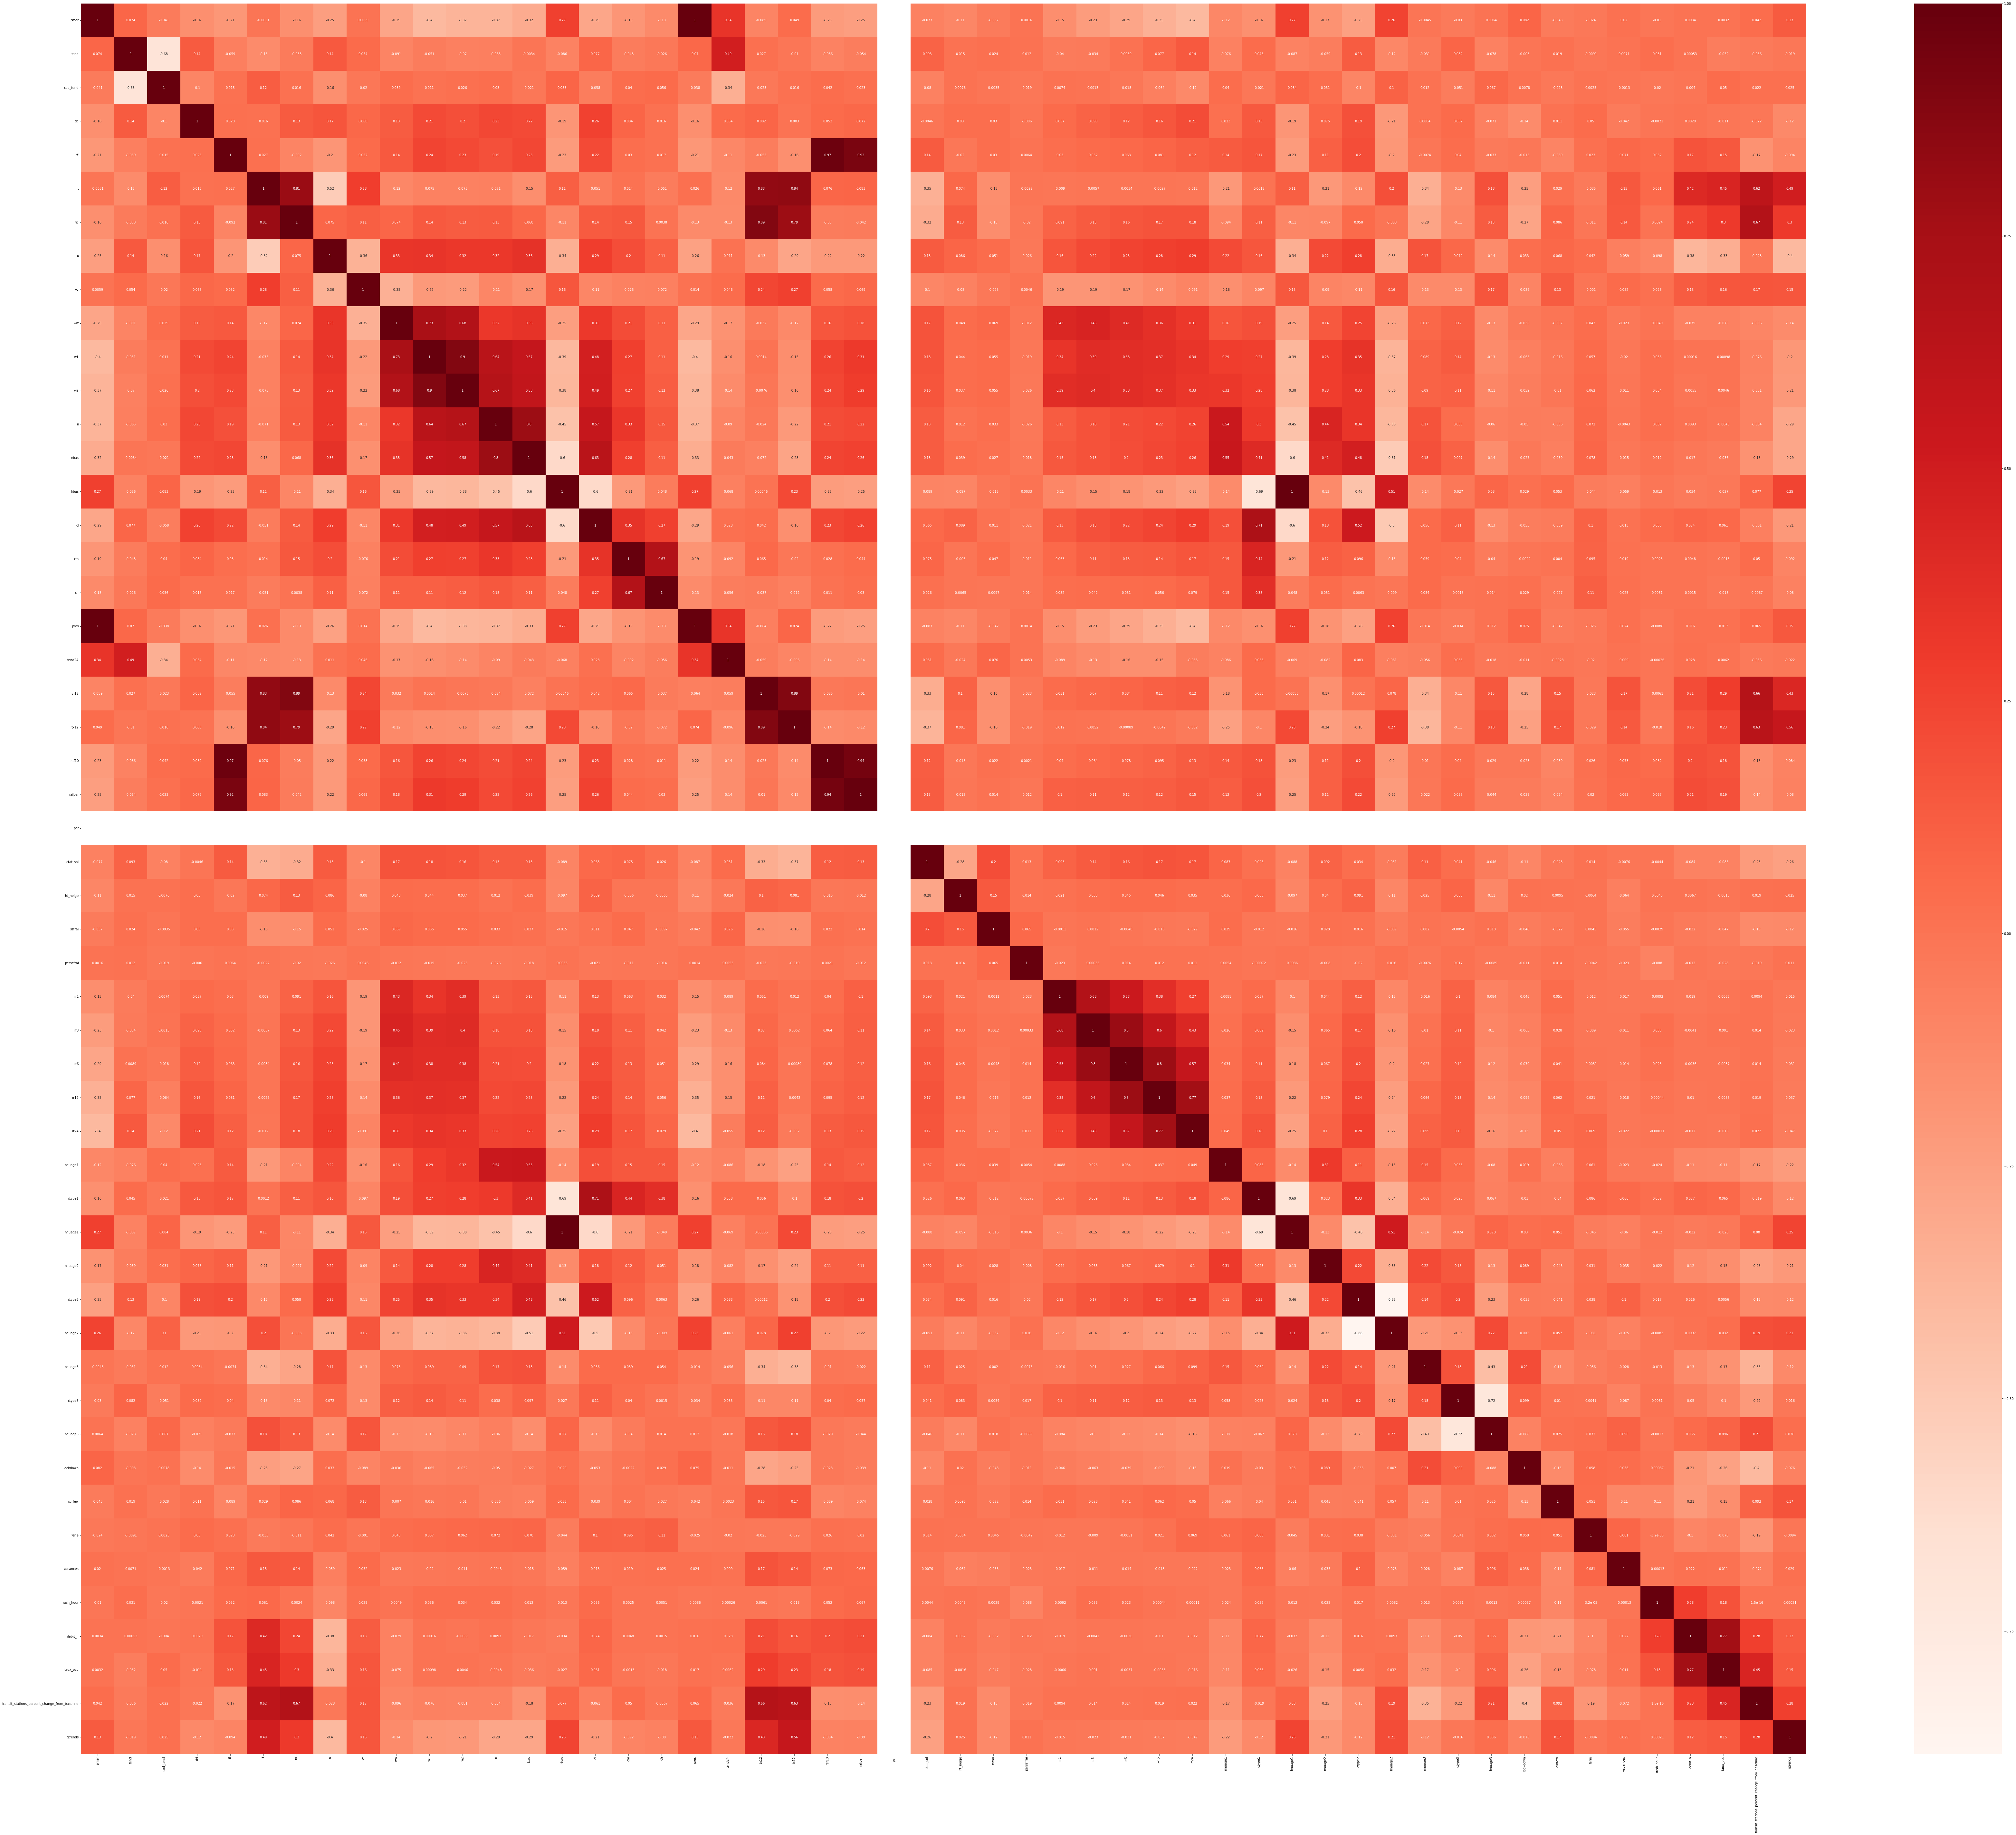

In [54]:
plt.figure(figsize=(120,100))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('fselect.png')
plt.show()

<AxesSubplot:xlabel='date'>

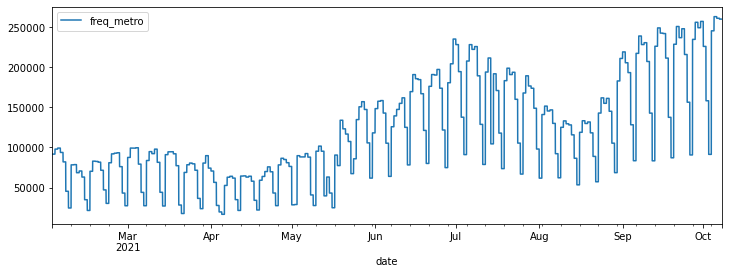

In [61]:
mask = ((df['date'] > pd.to_datetime('2021/02/01'))
        & (df['date'] < pd.to_datetime('2021/10/08')))

df_viz = df.loc[mask].copy()
#df_viz[''] = np.exp(y_test[mask.values]) - 1

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='freq_metro', ax=ax)

<AxesSubplot:xlabel='date'>

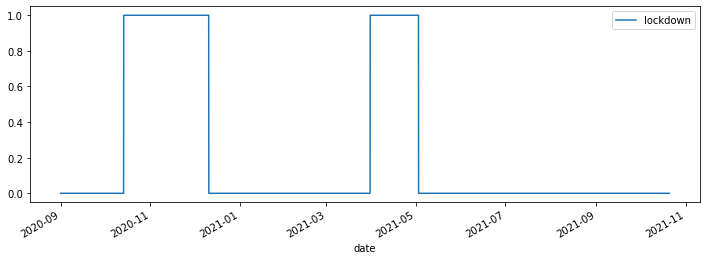

In [62]:
mask = ((df['date'] > pd.to_datetime('2020/09/01'))
        & (df['date'] < pd.to_datetime('2021/10/21')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='lockdown', ax=ax)

<AxesSubplot:xlabel='date'>

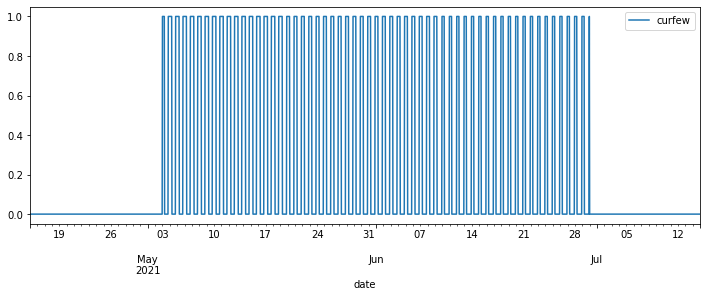

In [63]:
mask = ((df['date'] > pd.to_datetime('2021/04/15'))
        & (df['date'] < pd.to_datetime('2021/07/15')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='curfew', ax=ax)

<AxesSubplot:xlabel='date'>

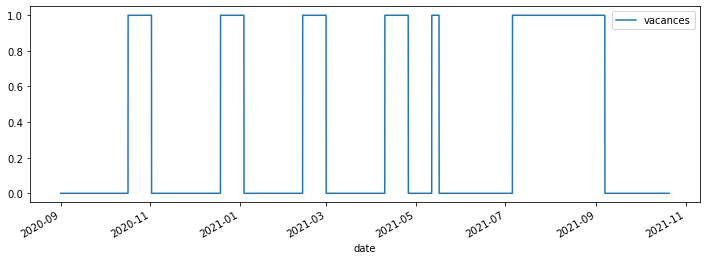

In [64]:
mask = ((df['date'] > pd.to_datetime('2020/09/01'))
        & (df['date'] < pd.to_datetime('2021/10/21')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='vacances', ax=ax)

<AxesSubplot:xlabel='date'>

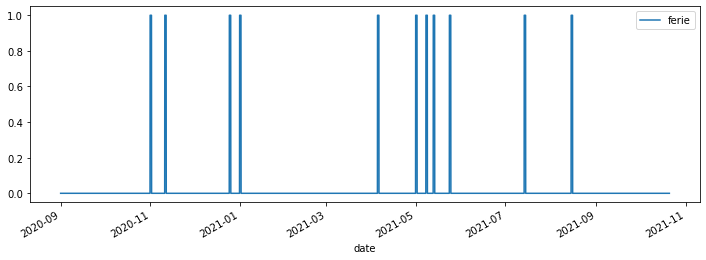

In [65]:
mask = ((df['date'] > pd.to_datetime('2020/09/01'))
        & (df['date'] < pd.to_datetime('2021/10/21')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='ferie', ax=ax)

<AxesSubplot:xlabel='date'>

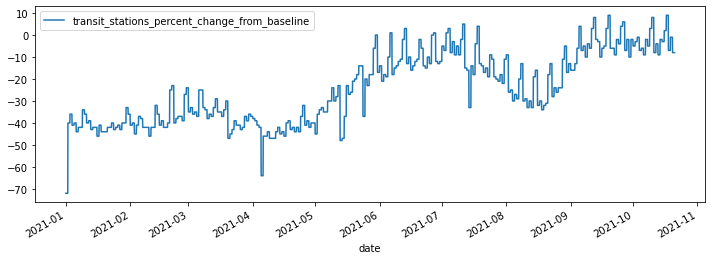

In [66]:
mask = ((df['date'] > pd.to_datetime('2020/09/01'))
        & (df['date'] < pd.to_datetime('2021/10/21')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='transit_stations_percent_change_from_baseline', ax=ax)

<AxesSubplot:xlabel='date'>

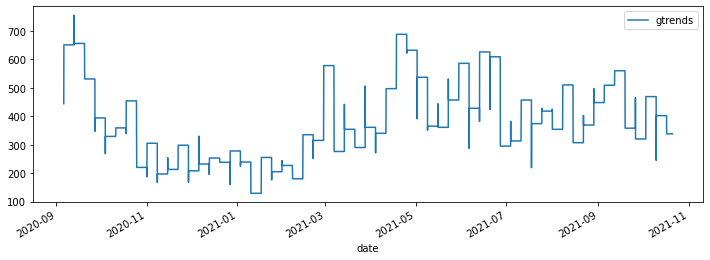

In [67]:
mask = ((df['date'] > pd.to_datetime('2020/09/01'))
        & (df['date'] < pd.to_datetime('2021/10/21')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='gtrends', ax=ax)

<AxesSubplot:xlabel='date'>

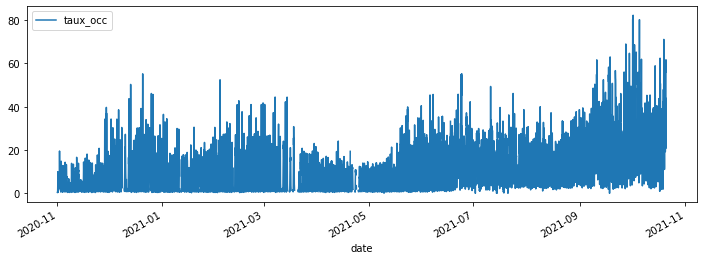

In [68]:
mask = ((df['date'] > pd.to_datetime('2020/09/01'))
        & (df['date'] < pd.to_datetime('2021/10/21')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='taux_occ', ax=ax)

<AxesSubplot:xlabel='date'>

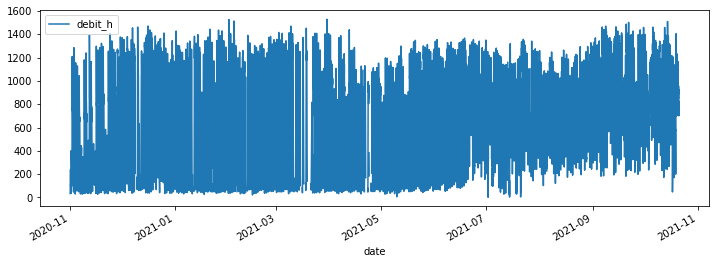

In [69]:
mask = ((df['date'] > pd.to_datetime('2020/09/01'))
        & (df['date'] < pd.to_datetime('2021/10/21')))

df_viz = df.loc[mask].copy()

fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='debit_h', ax=ax)